In [1]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("sanbei101/fruits")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruits


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前使用的设备: {device}")

当前使用的设备: cuda


In [3]:
# 定义训练集变换:包含数据增强
train_transform = transforms.Compose([
    transforms.Resize((100, 100)), # Fruits 360 原始为 100x100
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 定义测试集变换:仅标准化
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# 设置路径
train_dir = "/kaggle/input/fruits/fruits/train"
test_dir = "/kaggle/input/fruits/fruits/test"

# 加载数据
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
full_test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# 定义 DataLoader
train_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(full_test_dataset, batch_size=256, shuffle=False)

# 获取类别名称和数量
class_names = full_train_dataset.classes
num_classes = len(class_names)
print(f"检测到类别总数: {num_classes}")

检测到类别总数: 10


In [5]:
# 构建简单 CNN 序列模型
model_cnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # 输出 50x50
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # 输出 25x25
    nn.Flatten(),
    nn.Linear(32 * 25 * 25, 256),
    nn.ReLU(),
    nn.Linear(256, num_classes)
).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
print("Simple CNN 已就绪")

Simple CNN 已就绪


In [6]:
print("开始训练 Simple CNN...")
for epoch in range(5):
    model_cnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

开始训练 Simple CNN...
Epoch 1, Loss: 0.9560
Epoch 2, Loss: 0.1175
Epoch 3, Loss: 0.0413
Epoch 4, Loss: 0.0209
Epoch 5, Loss: 0.0118


In [7]:
from torchvision.models import resnet18, ResNet18_Weights

# 获取最新的预训练权重
weights = ResNet18_Weights.DEFAULT

# 加载模型
model_resnet = resnet18(weights=weights)

model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet = model_resnet.to(device)


# 使用较小的学习率进行微调
optimizer_res = optim.Adam(model_resnet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer_res, step_size=5, gamma=0.1)

print("ResNet18 迁移学习已就绪。")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]

ResNet18 迁移学习已就绪。


In [8]:
print("开始强化训练 ResNet18...")
for epoch in range(10): # 增加到 10 轮
    model_resnet.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_res.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_res.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    scheduler.step() # 每一轮更新学习率策略
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Accuracy: {acc:.2f}%, LR: {scheduler.get_last_lr()[0]}")

开始强化训练 ResNet18...
Epoch 1, Accuracy: 92.87%, LR: 0.0001
Epoch 2, Accuracy: 100.00%, LR: 0.0001
Epoch 3, Accuracy: 100.00%, LR: 0.0001
Epoch 4, Accuracy: 100.00%, LR: 0.0001
Epoch 5, Accuracy: 100.00%, LR: 1e-05
Epoch 6, Accuracy: 100.00%, LR: 1e-05
Epoch 7, Accuracy: 100.00%, LR: 1e-05
Epoch 8, Accuracy: 100.00%, LR: 1e-05
Epoch 9, Accuracy: 100.00%, LR: 1e-05
Epoch 10, Accuracy: 100.00%, LR: 1.0000000000000002e-06



分类报告:
              precision    recall  f1-score   support

       apple       0.98      0.64      0.77      1000
      banana       0.89      1.00      0.94       645
    cucumber       0.95      0.91      0.93      1000
    eggplant       0.85      0.91      0.88       236
       grape       0.93      0.81      0.87      1000
       mango       0.73      1.00      0.85       410
      orange       0.49      1.00      0.66       160
  strawberry       1.00      1.00      1.00       410
      tomato       0.88      0.99      0.93      1000
  watermelon       1.00      1.00      1.00       157

    accuracy                           0.89      6018
   macro avg       0.87      0.93      0.88      6018
weighted avg       0.91      0.89      0.89      6018



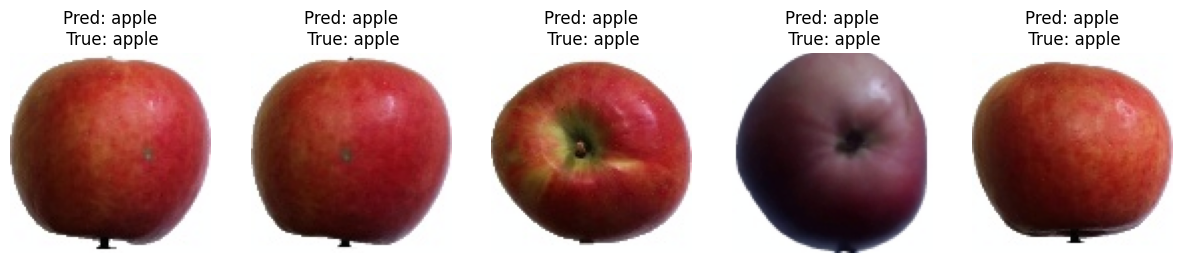

In [9]:
# 切换到评价模式
model_resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 打印分类报告
print("\n分类报告:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 可视化前 5 张测试图的预测结果
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model_resnet(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    # 反归一化
    img = np.clip(np.array([0.229, 0.224, 0.225]) * img + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\n True: {class_names[labels[i]]}")
    plt.axis('off')
plt.show()

In [10]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 8.0 MB/s eta 0:00:00


In [11]:
# 准备虚拟输入
dummy_input = torch.randn(1, 3, 100, 100).to(device)

onnx_path = "/kaggle/working/fruit_model.onnx"
batch = torch.export.Dim("batch", min=1, max=1024)
dynamic_shapes = {"x": {0: batch}}
torch.onnx.export(
    model_resnet,
    dummy_input, 
    onnx_path,
    export_params=True,
    opset_version=21,
    do_constant_folding=True,
    input_names=['x'],
    output_names=['output'],
    dynamic_shapes=dynamic_shapes,
    dynamo=True
)

print(f"模型已导出: {onnx_path}")

[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
模型已导出: /kaggle/working/fruit_model.onnx


In [12]:
!pip install onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.0 MB/s eta 0:00:00


In [13]:
import onnx

model = onnx.load("/kaggle/working/fruit_model.onnx")

onnx.save_model(
    model, 
    "fruit_model_combined.onnx", 
    save_as_external_data=False
)

In [14]:
import onnxruntime as ort
import numpy as np
import os, random
from PIL import Image

session = ort.InferenceSession('/kaggle/working/fruit_model_combined.onnx')
targets = sorted(['apple', 'banana', 'orange', 'strawberry', 'tomato', 'cucumber', 'eggplant', 'grape', 'mango', 'watermelon'])

for target in targets:
    print(f"\n正在测试类别: {target.upper()}")
    folder_path = os.path.join('/kaggle/input/fruits/fruits/test', target)
    sample_files = random.sample(os.listdir(folder_path), 10) # 随机抽3张

    for file_name in sample_files:
        # 读取并预处理图片
        img = Image.open(os.path.join(folder_path, file_name)).convert('RGB').resize((100, 100))
        img_data = np.array(img).transpose(2, 0, 1).astype(np.float32) / 255.0
        
        # 减去均值并除以标准差
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        for i in range(3):
            img_data[i] = (img_data[i] - mean[i]) / std[i]

        outputs = session.run(['output'], {'x': img_data[None, ...]})
        pred_idx = np.argmax(outputs[0])
        pred_name = targets[pred_idx]

        status = "✅ 成功" if pred_name == target else f"❌ 失败 (预测为: {pred_name})"
        print(f"  图片 {file_name}: {status}")


正在测试类别: APPLE
  图片 apple_420.jpg: ✅ 成功
  图片 apple_284.jpg: ✅ 成功
  图片 apple_22.jpg: ✅ 成功
  图片 apple_970.jpg: ❌ 失败 (预测为: tomato)
  图片 apple_297.jpg: ✅ 成功
  图片 apple_903.jpg: ❌ 失败 (预测为: mango)
  图片 apple_87.jpg: ✅ 成功
  图片 apple_625.jpg: ✅ 成功
  图片 apple_844.jpg: ❌ 失败 (预测为: mango)
  图片 apple_474.jpg: ❌ 失败 (预测为: grape)

正在测试类别: BANANA
  图片 banana_331.jpg: ✅ 成功
  图片 banana_418.jpg: ✅ 成功
  图片 banana_52.jpg: ✅ 成功
  图片 banana_564.jpg: ✅ 成功
  图片 banana_576.jpg: ✅ 成功
  图片 banana_436.jpg: ✅ 成功
  图片 banana_632.jpg: ✅ 成功
  图片 banana_107.jpg: ✅ 成功
  图片 banana_58.jpg: ✅ 成功
  图片 banana_503.jpg: ✅ 成功

正在测试类别: CUCUMBER
  图片 cucumber_791.jpg: ✅ 成功
  图片 cucumber_895.jpg: ✅ 成功
  图片 cucumber_968.jpg: ✅ 成功
  图片 cucumber_672.jpg: ❌ 失败 (预测为: banana)
  图片 cucumber_206.jpg: ✅ 成功
  图片 cucumber_348.jpg: ✅ 成功
  图片 cucumber_323.jpg: ✅ 成功
  图片 cucumber_784.jpg: ✅ 成功
  图片 cucumber_861.jpg: ✅ 成功
  图片 cucumber_416.jpg: ✅ 成功

正在测试类别: EGGPLANT
  图片 eggplant_133.jpg: ✅ 成功
  图片 eggplant_141.jpg: ✅ 成功
  图片 eggplant_49.jpg: ✅ 